In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from src.env.DunderBotEnv import DunderBotEnv
import src.run as run
import src.load as load

loading config from config/config.yml
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.util.config import get_config
config = get_config()

# TODO:

- figure out how to normalize values properly
    * do we have to account for prediction as well? That is, can/should we predict using values outside of 0-1 range?
    * Use: https://github.com/hill-a/stable-baselines/issues/820
- normalize the action space?
- understand the rendering during learning
- Add env checker
- untangle index weirdness (basically, try to enable prediction the last timestep, and make running interface easier (and more robust))
    * This will help (at the end) https://github.com/hill-a/stable-baselines/issues/779
- Change policy network (need to understand terminology surronding it, e.g. envoronment, n_steps etc). See also discussion here (and elsewhere among Issues: https://github.com/hill-a/stable-baselines/issues/759)
- Check/Enable/Add exploration noise (for PPO2, use the entropy flag), use https://stable-baselines.readthedocs.io/en/master/common/schedules.html
- lock down the seeds (and decide in config from a few specific ones)
- setup performance output, what we need to make data driven decision
    *e.g. https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/1_getting_started.ipynb#scrollTo=63M8mSKR-6Zt
- Add benchmarks
- Add more checks and tests
- Find as long time series of BTCUSD hourly data as possible, quite shortright now
- Add finer temporal resolution in data (generate/download multiple granularity)
- Check float number type
- self.stationarize_rewards?
- Enable saveing/loading trained models


# DONE: 
- add config
- modularize rewards
- own actions
- add more detailed actions for buy and sell amounts (still Discrete, I believe)
- wrap running code in function in main.py (to enable more dynamic data loading and train/test)
- own observations
- remove the bias when getting the observations (suggestion in the repo issues)
- download more interesting data and manually preprocess
- load interesting data, specified in config
- understand the time steps in learn and predict
- setup basic monitoring of training using TensorBoard
- Visualize basic performance
- Add support for fractions of shares
- Understand what should belong in what timestep (also decide on which price to plot as a result)
- add distributions of actions as output during prediction
- Refactor `_take_action` (might be something off in some calculations, also update terminology)
- Add commission and slippage
- Refactor current reward and add some new ones
- Add smallest amount of bitcoin we can own, as well as trading precision
- Add portfolio features
- Add reward output
- setup train/test functionality

# Run

In [5]:
%%time
df = load.load_OHLC_data()
env = run.preprocess(df=df)
model = run.train(env=env, timesteps=20000)

21628 5000 26628




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Resetting to timesteps: start 9, end 21628.
---------------------------------------
| approxkl           | 6.9840107e-06  |
| clipfrac           | 0.0            |
| explained_variance | -0.233         |
| fps                | 112            |
| n_updates          | 1              |
| policy_entropy     | 2.1972172      |
| policy_loss        | -0.00079543306 |
| serial_timesteps   | 128            |
| time_elapsed       | 0.000333       |
| total_timesteps    | 128            |
| value_loss         | 2.3904524e-05  |
---------------------------------------
--------------------------------------
| approxkl           | 7.738595e-05  |
| clipfrac           | 0.0           |
| explained_variance | -0.112        |
| fps                | 1

---------------------------------------
| approxkl           | 3.0270017e-05  |
| clipfrac           | 0.0            |
| explained_variance | 0.476          |
| fps                | 110            |
| n_updates          | 80             |
| policy_entropy     | 2.146478       |
| policy_loss        | -0.00027032616 |
| serial_timesteps   | 10240          |
| time_elapsed       | 83.6           |
| total_timesteps    | 10240          |
| value_loss         | 5.2594646e-06  |
---------------------------------------
---------------------------------------
| approxkl           | 4.7949692e-05  |
| clipfrac           | 0.0            |
| explained_variance | 0.222          |
| fps                | 106            |
| n_updates          | 90             |
| policy_entropy     | 2.1661375      |
| policy_loss        | -0.00096397777 |
| serial_timesteps   | 11520          |
| time_elapsed       | 95.9           |
| total_timesteps    | 11520          |
| value_loss         | 2.0577409e-06  |


Predicting for 4989 timesteps
21628 5000 26628
Resetting to timesteps: start 21638, end 26628.
Rendering TradingChartStatic for index steps 21638 through 26627
21638 26627


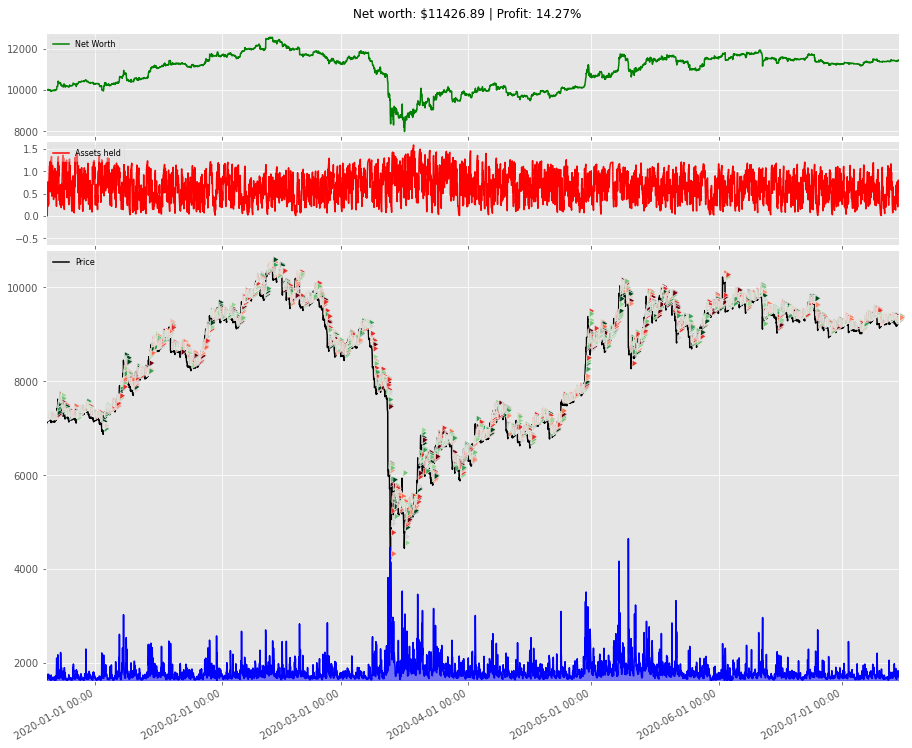

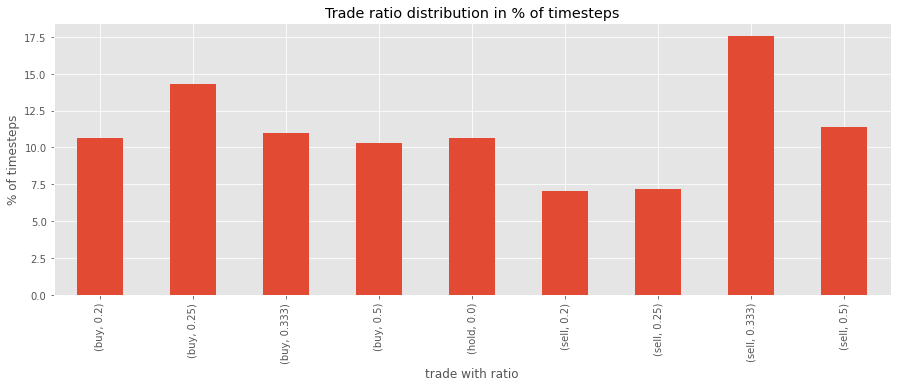

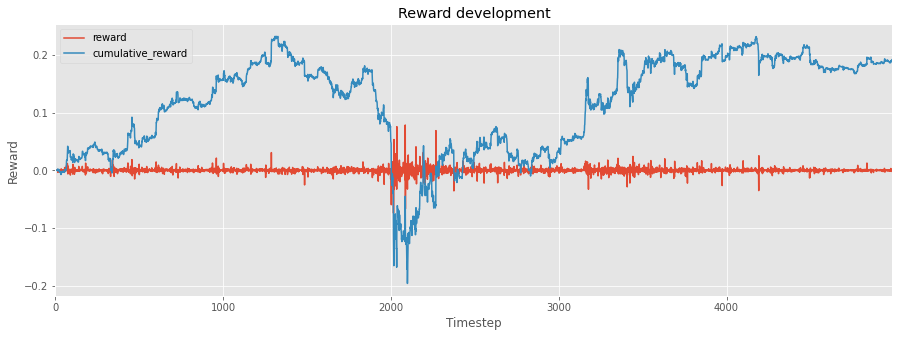

CPU times: user 3min 10s, sys: 7.41 s, total: 3min 17s
Wall time: 3min 17s


In [6]:
%%time
timesteps = config.train_test.test_timesteps - config.data_n_timesteps - 1
print(f'Predicting for {timesteps} timesteps')
run.predict(df=df, model=model, timesteps=timesteps, rendermode='human')

In [6]:
import pickle
with open('all_dict_pred.pickle', 'rb') as f:
    x = pickle.load(f)
x

{'current_step': 18,
 'net_worths': [10000.0,
  10000.0,
  10000.0,
  10001.7,
  9993.31,
  9845.08,
  9818.83,
  9857.64,
  9811.18,
  9826.9,
  9849.13,
  9841.65,
  9846.6,
  9906.72,
  9857.82,
  9825.55,
  9844.28,
  9835.73,
  9843.79,
  9853.91,
  9847.28,
  9858.84,
  9884.08,
  9846.62,
  9846.11,
  9859.04,
  9865.74,
  9849.82,
  9871.96,
  9886.04,
  9852.41,
  9828.36,
  9781.67,
  9796.26,
  9789.61,
  9787.16,
  9798.66,
  9821.71,
  9819.04,
  9825.21,
  9813.02,
  9817.28,
  9809.9,
  9810.35,
  9815.73,
  9852.16,
  9844.47,
  9845.15,
  9833.28,
  9836.58,
  9863.32,
  9843.26,
  9846.9,
  9838.6,
  9843.73,
  9840.44,
  9971.54,
  9981.18,
  9980.54,
  9981.68,
  9980.22,
  9984.06,
  10005.04,
  9992.58,
  9998.53,
  10012.4,
  10006.93,
  9995.75,
  9951.78,
  9922.8,
  9824.37,
  9840.96,
  9803.94,
  9764.1,
  9780.03,
  9798.29,
  9787.19,
  9793.24,
  9805.33,
  9789.97,
  9796.14,
  9795.5,
  9814.97,
  9812.16,
  9803.83,
  9817.89,
  9804.12,
  9807.79,
  9

In [8]:
x.keys()

dict_keys(['current_step', 'net_worths', 'trades', 'account_history', 'rewards'])

In [8]:
import pandas as pd
net_worths = pd.Series(x['net_worths'], index=range(self.start_step, self.end_step+1))

NameError: name 'self' is not defined

# Traintest TODO:
- Make sure the overlap is 0 (I think it is 1 right now)